# Natural Language Processing - Exercise 5 (Problem 2)

## Authors
* Charteros Eleftherios ([l.harteros@gmail.com](mailto:l.harteros@gmail.com))
* Kotitsas Sotirios ([sotiriskot9@gmail.com](mailto:sotiriskot9@gmail.com))
* Stavropoulos Petros ([pstav1993@gmail.com](mailto:pstav1993@gmail.com))
* Xenouleas Efstratios ([stratosxen@gmail.com](mailto:stratosxen@gmail.com))

# Load Libraries

In [ ]:
# Install latests tqdm and hyperopt
# (restart of notebook required)
!pip install --upgrade tqdm
!pip install hyperopt

Requirement already up-to-date: tqdm in /usr/local/lib/python3.6/dist-packages (4.45.0)


In [ ]:
# Import everything
import gensim.downloader as api
import pandas as pd
import pickle
import numpy as np
import os
import re
import random
import sys
import nltk
import pdb
import sklearn
import time
import torch
import torch.nn as nn
import torch.nn.functional as F

from copy import deepcopy
from hyperopt import fmin, tpe, hp, STATUS_OK, Trials, pyll
from nltk import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer, PorterStemmer
from sklearn.metrics import auc, average_precision_score, precision_recall_curve
from torch.autograd import Variable
from torch.nn.parameter import Parameter
from torch.optim import SGD, Adam, RMSprop
from torch.nn import BCEWithLogitsLoss
from torch.nn.modules.module import Module
from torch.nn.utils.rnn import pack_padded_sequence
from torch.utils.data import Dataset, DataLoader
from tqdm import tqdm_pandas
from tqdm.autonotebook import tqdm

import matplotlib.pyplot as plt

# Set tqdm to pandas to print to stdout
tqdm.pandas(file=sys.stdout)

In [ ]:
# Download nltk data needed
nltk.download('punkt')
nltk.download('wordnet')
nltk.download("stopwords")

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [ ]:
# Set seeds
random.seed(0)
np.random.seed(0)
torch.manual_seed(0)
torch.cuda.manual_seed(0)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

# Kaggle config

In [ ]:
# 1. Go to https://www.kaggle.com/c/twitter-sentiment-analysis2/data
# 1.a. Join the competition
# 1.b. Accept the terms in order to be able to download the data
# 2. Go to 'My account' on kaggle and press 'Create Api token'. 
# A file named 'kaggle.json' should be downloaded.
# Colab library to upload files. Upload 'kaggle.json'
# If it crashes either re-run it or download the train.csv data
# from the link above and upload it to colab (same directory as sample data)
from google.colab import files
files.upload()

# The kaggle.json config file needs to be located in /root/.kaggle
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle
!chmod 600 ~/.kaggle/kaggle.json

# Downlaod data for the twitter-sentiment-analysis Challenge
!kaggle competitions download -c twitter-sentiment-analysis2

# Unzip the downloaded data
!unzip train.csv.zip

Saving kaggle.json to kaggle.json
 82% 9.00M/11.0M [00:00<00:00, 30.2MB/s]
100% 11.0M/11.0M [00:00<00:00, 36.6MB/s]
  0% 0.00/3.67M [00:00<?, ?B/s]
100% 3.67M/3.67M [00:00<00:00, 122MB/s]
Archive:  train.csv.zip
  inflating: train.csv               


# Data Preprocessing

## Preprocess data

In [ ]:
# Method that preprocesses a sentence
def preprocess(x):

    # Make text lower case
    x = x.lower()

    # Remove tags of other people
    x = re.sub(r"@\w*", " ", x)

    # Remove special characters
    x = re.sub(r"#|^\*|\*$|&quot;|&gt;|&lt;|&lt;3", " ", x)
    x = x.replace("&amp;", " and ")

    # Remove links
    x = re.sub(r"ht+p+s?://\S*", " ", x)

    # Remove non-ascii
    x = re.sub(r"[^\x00-\x7F]", " ", x)

    # Remove time 
    x = re.sub(r"((a|p).?m)?\s?(\d+(:|.)?\d+)\s?((a|p).?m)?", " ", x)

    # Remove brackets if left after removing time
    x = re.sub(r"\(\)|\[\]|\{\}", " ", x)

    # For words we want to keep at least two occurences of 
    #  each word(e.g not change good to god)
    x = re.sub(r"([a-z])\1+", r"\1\1", x)

    # For special characters we want to keep only one occurence
    x = re.sub(r"([\?\-\.\\/!:~;_\[\]\{\}\(\)])\1+", r"\1", x)

    # Emojis
    x = re.sub(
        r"([\(\[\{\*][\-\^'._]?[:;x]|[:;][\-\^'._]?[pd3\)\]\}\*]|\s[x][\-\^'._]?[abdeop3\)\]\}]\s|<3|[\(]?\^[\-\^'._]?\^[\)]?)",
        " happyemoji ", x)
    x = re.sub(
        r"([:;][\-\^'._]?[o0\(\[\{\\/\|\$]|[x][\-\^'._]?[x\(\[\}\|\\/\$]|[o0][\-\^'._][o0\(\[\}\|\\/\$]|[t][\-\^'._][t\(\[\}\|\\/\$]|[>~][\-\^'._]?[<~])",
        " sademoji ", x)

    # Remove any string that starts with number
    x = re.sub(r"\d[\w]*", " ", x)

    # Remove all special characters left that were not classified as emoji
    x = re.sub(r"[^a-zA-Z0-9 ]", "", x)

    # Remove single letters that left 
    x = re.sub(r"\s[b-z]\s", " ", x)

    # Remove multiple space chars
    x = " ".join(x.split())

    return x

# Read the dataset from the train.csv
data = pd.read_csv("train.csv", encoding="ISO-8859-1")

# Preprocess dataset
print("Preprocessing dataset ...\n")
data.SentimentText = data.SentimentText.progress_apply(lambda x: preprocess(x))

Preprocessing dataset ...



## Split data into train, dev and test sets

In [ ]:
# Method that splits the data into train-dev-test
# (we create the dev-test from train.csv so that we have the correct labels for the metrics)
def train_val_test_split(data, split=0.8):
    train_size = int(len(data) * split)
    test_size = train_size + int((len(data) - train_size) / 2)

    train = data[:train_size]
    val = data[train_size:test_size]
    test = data[test_size:]

    return train, val, test

# Split to train, validation and test sets
print("\nSplitting dataset ...\n")
train_set, val_set, test_set = train_val_test_split(data)


Splitting dataset ...



## Create datasets

In [ ]:
class TweetDataset(Dataset):

    def __init__(self, tweet_corpus):
        self.data = tweet_corpus
        self.data_text = list(tweet_corpus.SentimentText)
        self.data_labels = list(tweet_corpus.Sentiment)
        # self.data_text = tweet_corpus.SentimentText
        # self.data_labels = tweet_corpus.Sentiment
        self.how_many = len(self.data)

    def __len__(self):
        """Denotes the total number of samples"""
        return self.how_many

    def __getitem__(self, index):
        return {'tweet': self.data_text[index],
                'label': self.data_labels[index]}

In [ ]:
# Create the train, dev and test datasets from the train, dev and test sets
train_dataset = TweetDataset(train_set)
dev_dataset = TweetDataset(val_set)
test_dataset = TweetDataset(test_set)

## Create vocab

In [ ]:
# Auxiliary Vocab class
class Vocab:

    # Method that initializes variables and loads the embeddings
    def __init__(self, tweets, model_name):
        self.word2idx = {}
        self.word_embeddings = []
        self.idx2word = dict()
        self.embeddings = api.load(model_name)
        self.embedding_dim = self.embeddings.vector_size
        self._create_vocab(tweets)

    def _create_vocab(self, tweets):
        """
        Creates the vocab given some tweets
        Args:
          tweets (pd.TimeSeries): Containes the tweets
        """

        # Create and add a PAD token with zero values
        self.word2idx['PAD'] = 0
        self.word_embeddings.append(np.zeros(self.embedding_dim))

        # Create and add a @UNK token with random values
        self.word2idx['@UNK'] = len(self.word2idx)
        self.word_embeddings.append(np.random.randn(self.embedding_dim))

        # Iterate through the tweets and update the vocab with each word
        for tweet in tqdm(tweets):
            for word in tweet.split():
                if word not in self.word2idx:
                    # Add a word to the vocab only if it is in the embeddings
                    if word in self.embeddings:
                        self.word2idx[word] = len(self.word2idx)
                        self.word_embeddings.append(self.embeddings[word])
        
        self.word_embeddings = np.array(self.word_embeddings)
        
        # We can also set the unkown to be the average of all the other embeddings
        #  except the PAD and @UNK token
        self.word_embeddings[1] = np.mean(self.word_embeddings[2:], axis=0)

        # Create an inverse vocab dicrionary
        self.idx2word = dict(zip(self.word2idx.values(), self.word2idx.keys()))

    def get_index(self, word):
        """
        Returns the index of the word with respect to the vocab order

        Args:
          word(str): A single word 
        """
        try:
          return self.word2idx[word]
        except KeyError:
          return self.word2idx['@UNK']
        
    def phr2idx(self, phr):
        """
        Tranforms a sentence to the indices of its words

        Args:
          phr(str): A sentence (phrase)
        """

        return [self.get_index(t) for t in phr.split()]

In [ ]:
# Create the vocab
vocab = Vocab(tweets=train_set.SentimentText, model_name="glove-twitter-100")

[================================================--] 96.0% 371.7/387.1MB downloaded

# Model Configuration, Training and Evaluation

## Create models

In [ ]:
# Dummy classifier that predicts the majority class 
class DummyClassifier(Module):
    def __init__(self, train_dataset):
        super(DummyClassifier, self).__init__()

        if max(train_dataset.data_labels)==0:
            self.majority=-1000
        else:
            self.majority=1000

    def forward(self, tweets):
        return torch.full((tweets[0].shape[0],),self.majority)

In [ ]:
# Logistic Regression Classifier Model
class LogisticRegressor(Module):
    def __init__(self, word_embeddings):
        super(LogisticRegressor, self).__init__()

        # Initialize the embedding layer from the pretrained embeddings and set it
        #  to frozen, so that the weifhts are not updated
        self.embedding_layer = nn.Embedding.from_pretrained(torch.FloatTensor(word_embeddings), freeze=True,
                                                            padding_idx=0)

        # Initialize the layer of the LR
        self.linear = nn.Linear(word_embeddings.shape[1], 1, bias=True)
        self.init_weights()

    def init_weights(self):
        # Initialize the weights of the model
        nn.init.xavier_uniform_(self.linear.weight)

    def get_words_embeds(self, tweet):
        # Get the word embeddings of the tweet
        return self.embedding_layer(tweet)

    def forward(self, tweets):
  
        # First fix the input (padding) / map the tweets to word embeddings
        tweet_embs = self.get_words_embeds(tweets[0])

        # Find the mean of the embeddings respecting the tweet lengths and set it
        #  as the sentence embedding
        sent_emb = tweet_embs.sum(dim=1) / tweets[1].sum(dim=1).unsqueeze(dim=1)

        # Pass the sentence embedding through the linear layer
        output = self.linear(sent_emb)

        return output.squeeze()


In [ ]:
# MLP Classifier Model
class MLPClassifier(Module):
    def __init__(self, word_embeddings, hid_sizes=[128], dropout=None):
        super(MLPClassifier, self).__init__()

        # We will use the leaky relu activation function
        self.leaky_relu = F.leaky_relu

        # Initialize the dropout
        if dropout is None:
            dropout = 0.0
        self.dropout = nn.Dropout(dropout)

        # Initialize the embedding layer from the pretrained embeddings and set it
        #  to frozen, so that the weifhts are not updated
        self.embedding_layer = nn.Embedding.from_pretrained(torch.FloatTensor(word_embeddings), freeze=True,
                                                            padding_idx=0)

        # Initialize the MLP input and hidden layers dynamically from the hid_sizes array
        self.hidden = nn.ModuleList()
        self.hidden.append(nn.Linear(word_embeddings.shape[1], hid_sizes[0], bias=True))

        for k in range(len(hid_sizes) - 1):
            self.hidden.append(nn.Linear(hid_sizes[k], hid_sizes[k + 1], bias=True))

        # Initialize the output layer
        self.hidden.append(nn.Linear(hid_sizes[-1], 1, bias=True))

        # Initialize the weights
        self.init_weights()

    def init_weights(self):
        # Initialize the weights of the hidden layers
        for hid in self.hidden:
            nn.init.xavier_uniform_(hid.weight)

    def get_words_embeds(self, tweet):
      # Get the word embeddings of the tweet
        return self.embedding_layer(tweet)

    def forward(self, tweets):

        # First fix the input (padding) / map the tweets to word embeddings
        tweet_embs = self.get_words_embeds(tweets[0])

        # Find the mean of the embeddings respecting the tweet lengths and set it
        #  as the sentence embedding
        sent_emb = tweet_embs.sum(dim=1) / tweets[1].sum(dim=1).unsqueeze(dim=1)

        # Pass sentence embedding though each layer and activation function
        #  and perform dropout
        for i in range(len(self.hidden) - 1):
            sent_emb = self.hidden[i](sent_emb)
            sent_emb = self.leaky_relu(sent_emb)
            sent_emb = self.dropout(sent_emb)

        # Don't pass output layer though leaky_relu and dropout
        output = self.hidden[-1](sent_emb)

        return output.squeeze()


In [ ]:
# RNN Classifier Model
class RNNClassifier(Module):
    def __init__(self,word_embeddings,
                 rnn_hidden_size,
                 rnn_layers,
                 bidirectional=True,
                 rnn_dropout=0.,
                 dropout=0.,
                 att_hid_sizes=[100, 50],
                 mlp_hid_sizes=[100, 50]):
        
        super(RNNClassifier, self).__init__()


        self.rnn_hidden_size = rnn_hidden_size

        self.leaky_relu = F.leaky_relu
        self.dropout = nn.Dropout(dropout)

        # Initialize the embedding layer from the pretrained embeddings and set it
        #  to frozen, so that the weifhts are not updated
        self.embedding_layer = nn.Embedding.from_pretrained(torch.FloatTensor(word_embeddings), freeze=True,
                                                            padding_idx=0)
        
        self.the_rnn = nn.GRU(input_size=word_embeddings.shape[1],
                              hidden_size=self.rnn_hidden_size,
                              num_layers=rnn_layers,
                              bidirectional=bidirectional,
                              bias=True,
                              dropout=rnn_dropout,
                              batch_first=True)

        # input size must be batch_size X seq_len X hidden_dim
        self.att_mlp = nn.ModuleList()
        self.att_mlp.append(nn.Linear(self.rnn_hidden_size, att_hid_sizes[0], bias=True))

        for k in range(len(att_hid_sizes) - 1):
            self.att_mlp.append(nn.Linear(att_hid_sizes[k], att_hid_sizes[k+1], bias=True))

        self.att_mlp.append(nn.Linear(att_hid_sizes[-1], 1, bias=True))
        self.softmax = nn.Softmax(dim=1)

        # final MLP to decide whether a tweet is negative or positive
        self.mlp = nn.ModuleList()
        self.mlp.append(nn.Linear(self.rnn_hidden_size, mlp_hid_sizes[0], bias=True))

        for k in range(len(mlp_hid_sizes) - 1):
            self.mlp.append(nn.Linear(mlp_hid_sizes[k], mlp_hid_sizes[k+1], bias=True))

        self.mlp.append(nn.Linear(mlp_hid_sizes[-1], 1, bias=True))

        self.init_weights()

    def init_weights(self, scale=1e-4):

        # Initialize the weights of the hidden layers of the att_mlp
        for hid in self.att_mlp:
            nn.init.xavier_uniform_(hid.weight)

        # Initialize the weights of the hidden layers of the final mlp
        for hid in self.mlp:
            nn.init.xavier_uniform_(hid.weight)

        # Initialize the weights of the rnn
        for param in self.the_rnn.parameters():
            nn.init.uniform_(param, a=-scale, b=scale)

    def get_words_embeds(self, word_idx):
        return self.embedding_layer(word_idx)

    def apply_self_attention(self, input_representation):

        # input_representation ---> batch_size x seq_len x hidden_dim
        # pass through the first layer
        out = self.leaky_relu(self.att_mlp[0](input_representation))

        # pass through the intermediate layers
        for layer in self.att_mlp[1:-1]:
            out = self.dropout(self.leaky_relu(layer(out)))

        # pass through the final layer
        out = self.att_mlp[-1](out).squeeze()

        # out ---> batch_size x seq_len
        # softmax to get the weights
        weights = self.softmax(out)

        # input_representation ---> batch_size x seq_len x hidden_dim
        # expand the weights as ---> batch_size x seq_len x hidden_dim
        # weighted ---> batch_size x seq_len x hidden_dim
        weighted = torch.mul(input_representation, weights.unsqueeze(2).expand_as(input_representation))

        # representation ---> batch_size x hidden_dim
        # we add in the dimensions of the words
        representation = weighted.sum(1)
        return representation

    def encode(self, inp, seq_lens=None, perm_idx=None):
        # Handling padding in Recurrent Networks
        gru_input = pack_padded_sequence(inp, seq_lens.data.cpu().numpy(), batch_first=True)
        output = self.the_rnn(gru_input)[0]

        # Unpack and pad
        output = torch.nn.utils.rnn.pad_packed_sequence(output, batch_first=True)[0]

        # split the two directions and add them instead of concat
        # the dimensions will stay the same so we can add the residuals
        out_forward = output[:, :, :self.rnn_hidden_size]
        out_backward = output[:, :, self.rnn_hidden_size:]
        output = out_forward + out_backward
        # residual
        output = output + inp

        # Un-sort by length to get the original ordering
        output = unsort(output, perm_idx, 0)

        # Pooling
        # apply self-attention
        return self.apply_self_attention(output)

    def get_rnn_representation(self, sent, sent_lens, sent_perm):
        sent_repr = self.encode(sent, sent_lens, sent_perm)
        return sent_repr

    def forward(self, input):

        input_lens, input_perm = input[2], input[3]

        input_embs = self.get_words_embeds(input[0])
        input_repr = self.get_rnn_representation(input_embs,
                                                 input_lens,
                                                 input_perm)

        # pass through the first layer
        out = self.leaky_relu(self.mlp[0](input_repr))

        # pass through the intermediate layers
        for layer in self.mlp[1:-1]:
            out = self.dropout(self.leaky_relu(layer(out)))

        # pass through the final layer
        out = self.mlp[-1](out).squeeze()

        return out

In [ ]:
# CNN Classifier Model
class CNNClassifier(Module):
    def __init__(self, word_embeddings,
                cnn_filter_size,                
                cnn_layers,
                n_grams = 2,
                cnn_dropout=0.,
                mlp_dropout=0.,
                hid_sizes=[100, 50]):
        
        super(CNNClassifier, self).__init__()

        self.leaky_relu = F.leaky_relu
        self.cnn_dropout = nn.Dropout(cnn_dropout)
        self.mlp_dropout = nn.Dropout(mlp_dropout)

        # Initialize the embedding layer from the pretrained embeddings and set it
        #  to frozen, so that the weifhts are not updated
        self.embedding_layer = nn.Embedding.from_pretrained(torch.FloatTensor(word_embeddings), freeze=True,
                                                            padding_idx=0)
        
        # Calculate padding based on ngram
        pad = (n_grams-1)
        top_pad = pad//2
        bot_pad = pad - top_pad
        self.padding = nn.ConstantPad2d((0,0,top_pad,bot_pad),0)
        
        # Initialize the CNN layers
        self.stacked_cnn = nn.ModuleList()
        self.stacked_cnn.append(nn.Conv2d(in_channels=1,out_channels=cnn_filter_size, kernel_size=(n_grams,word_embeddings.shape[1]), bias=True))

        for _ in range(1,cnn_layers):
            self.stacked_cnn.append(nn.Conv2d(in_channels=1,out_channels=cnn_filter_size, kernel_size=(n_grams,cnn_filter_size), bias=True))

        # Initialize the MLP input and hidden layers dynamically from the hid_sizes array
        self.mlp = nn.ModuleList()
        self.mlp.append(nn.Linear(cnn_filter_size, hid_sizes[0], bias=True))

        for k in range(len(hid_sizes) - 1):
            self.mlp.append(nn.Linear(hid_sizes[k], hid_sizes[k + 1], bias=True))

        # Initialize the output layer
        self.mlp.append(nn.Linear(hid_sizes[-1], 1, bias=True))

        self.init_weights()

    def init_weights(self, scale=1e-4):

        # Initialize the weights of the cnn layers
        for cnn_layer in self.stacked_cnn:
            nn.init.xavier_uniform_(cnn_layer.weight)

        # Initialize the weights of the hidden layers of the mlp
        for hid in self.mlp:
            nn.init.xavier_uniform_(hid.weight)

    def get_words_embeds(self, tweet):
      # Get the word embeddings of the tweet
        return self.embedding_layer(tweet)

    def forward(self, tweets):

        # Map the tweets to word embeddings
        # tweets_embs --> batch_size x sent_len x filters
        tweet_embs = self.get_words_embeds(tweets[0])

        # Add an extra dimension in order to align the sentence with the cnn
        # tweets_embs --> batch_size x 1 x sent_len x filters
        tweet_embs = tweet_embs.unsqueeze(1)

        # Find the mean of the embeddings respecting the tweet lengths and set it
        #  as the sentence embedding
        for i in range(len(self.stacked_cnn)):
            
            # Keep the input for the residual connection
            layer_input = tweet_embs

            # Pad input and feed forward through the cnn
            # tweets_embs --> batch_size x filters x sent_len x 1
            tweet_embs = self.stacked_cnn[i](self.padding(tweet_embs))

            # Reshape the output to the shape of the input in order
            # to be able to feed it to the next cnn 
            # tweets_embs --> batch_size x 1 x sent_len x filters
            tweet_embs = tweet_embs.reshape(-1,tweet_embs.shape[3],tweet_embs.shape[2],tweet_embs.shape[1])

            tweet_embs = self.leaky_relu(tweet_embs)
            tweet_embs = self.cnn_dropout(tweet_embs)

            if i!=0:
                # Apply the residual connection after first layer
                tweet_embs += layer_input

        # Pool the features of the tweets and get for each tweet its sentence embedding
        # tweets_embs.squeeze --> batch_size  x sent_len x filters
        # sent_emb --> batch_size x 1 x filters
        sent_emb = F.max_pool2d(tweet_embs.squeeze(),kernel_size=(tweet_embs.shape[2],1))

        # sent_emb --> batch_size x filters
        sent_emb = sent_emb.squeeze()

        # Pass sentence embedding though each layer and activation function
        #  and perform dropout
        for i in range(len(self.mlp) - 1):
            sent_emb = self.mlp[i](sent_emb)
            sent_emb = self.leaky_relu(sent_emb)
            sent_emb = self.mlp_dropout(sent_emb)

        # Don't pass output layer though leaky_relu and dropout
        output = self.mlp[-1](sent_emb)

        return output.squeeze()

## Create helper method to add fixed size input to the models

In [ ]:
# unsort tweets (rnn)
def unsort(output, perm_idx, dim=0):
    _, unperm_idx = perm_idx.sort(0)
    output = output.index_select(dim, unperm_idx)
    return output


def fix_input(tweet_idxs=None, model_name='RNNClassifier'):
    # Find the sequence lengths of the tweets
    seq_lengths_tweet = torch.LongTensor([len(seq) for seq in tweet_idxs])

    # Pad the tweets
    if model_name == 'RNNClassifier':
        tweet_phr, tweet_mask, tweet_lens, tweet_perm = pad_sequences(tweet_idxs, seq_lengths_tweet, True)
        return tweet_phr, tweet_mask, tweet_lens, tweet_perm
    else:
        tweet_phr, tweet_mask = pad_sequences(tweet_idxs, seq_lengths_tweet)
        return tweet_phr, tweet_mask
    


def pad_sequences(vectorized_seqs, seq_lengths, sort_bool=False):
    # Pads the vectorized sequences

    # Create a tensor for the sequences with zeroes of the shape of the
    #  max length tweet
    seq_tensor = torch.zeros((len(vectorized_seqs), seq_lengths.max())).long()

    # Create a tensor for the masks with zeroes of the shape of the
    #  max length tweet
    seq_mask = torch.zeros((len(vectorized_seqs), seq_lengths.max())).long()

    # For each vectorized sequence (tweet) add the values to the seq_tensor
    #  and add 1s to the seq_mask according to its length
    for idx, (seq, seq_len) in enumerate(zip(vectorized_seqs, seq_lengths)):
        seq_tensor[idx, :seq_len] = torch.LongTensor(seq)
        seq_mask[idx, :seq_len] = torch.LongTensor([1])

    # sorting the input for rnn
    perm_idx = None
    if sort_bool:
        # Sort tensors by their length
        seq_lengths, perm_idx = seq_lengths.sort(0, descending=True)
        seq_tensor = seq_tensor[perm_idx]
        return seq_tensor, seq_mask, seq_lengths, perm_idx
    else:
        return seq_tensor, seq_mask

## Create DataLoaders

In [ ]:
# Method that creates the DataLoaders (iterators) for the dataset using a batch size
def createDataLoaders(train_dataset,dev_dataset,test_dataset=None,batch_size=128):

    train_iterator = createDataLoader(dataset=train_dataset,batch_size=batch_size)

    dev_iterator = createDataLoader(dataset=dev_dataset,batch_size=batch_size)

    if test_dataset is None:
        test_iterator = None
    else:
        test_iterator = createDataLoader(dataset=test_dataset,batch_size=batch_size)
    
    return train_iterator,dev_iterator,test_iterator

# Method that creates a dataloader from a dataset using a batch size
def createDataLoader(dataset,batch_size=128):
    # Custom collate function that overrides the way that batches are
    #  made from the dataloader iterator
    def my_collate(batch):
        data, labels = [], []
        for item in batch:
            # Remove all tweets that don't have text
            if item['tweet'] != '':
                data.append(item['tweet'])
                labels.append(item['label'])
        return {'tweet': data, 'label': torch.FloatTensor(labels)}

    return DataLoader(dataset=dataset, collate_fn=my_collate,
                                batch_size=batch_size)

## Train function

In [ ]:
# Method that trains a model for an epoch
def train_epoch(model,optimizer,criterion,vocab,loader,device="cpu"):

    # Set the model to train mode
    model.train()

    # Initialize batch metric lists
    batch_loss = []
    batch_auc = []
    batch_prec = []

    # For every batch in the dataloader iterator
    for batch in loader:

        # Get the vocab indices of the tweets
        data = [vocab.phr2idx(tweet) for tweet in batch['tweet']]
        # Fix the input
        data = fix_input(data, type(model).__name__)

        # Send data to device
        # we must sort the input for the rnn
        if len(data) > 2:
            data = (data[0].to(device), data[1].to(device), data[2].to(device), data[3].to(device))
        else:
            data = (data[0].to(device), data[1].to(device))
        
        # Send targets to device
        target = batch['label'].to(device)
        # Zero the gradients of the optimizer
        optimizer.zero_grad()
        # Get the output from the model using a forward pass
        output = model(data)
        # Calculate the loss using the output and the targets
        loss = criterion(output, target)
        # Do a backward pass to fill the gradients
        loss.backward()
        # Do an optimizer step
        optimizer.step()
        # Append the metrics to the batch lists
        batch_loss.append(loss.cpu().item())
        # Calculate the precisions and recalls using sklearn
        precisions, recalls, _ = precision_recall_curve(target.cpu().detach().numpy(), torch.sigmoid(output).cpu().detach().numpy())
        batch_auc.append(auc(recalls, precisions))
        batch_prec.append(average_precision_score(target.cpu().detach().numpy(),torch.sigmoid(output).cpu().detach().numpy()))

    # Calculate the average batch metrics
    train_avg_loss = sum(batch_loss) / len(batch_loss)
    train_avg_auc = sum(batch_auc) / len(batch_auc)
    train_avg_prec = sum(batch_prec) / len(batch_prec)

    return train_avg_loss,train_avg_auc,train_avg_prec

## Validate function

In [ ]:
# Method that does a validation pass to the dev dataloader
def validate_epoch(model,criterion,vocab,loader,device="cpu"):
    # Code block in which torch does not keep gradients
    with torch.no_grad():
        # Set the model to evaluation mode
        model.eval()

        # Initialize batch metric lists
        batch_loss = []
        batch_auc = []
        batch_prec = []

        # For every batch in the dataloader iterator
        for batch in loader:

            # Get the vocab indices of the tweets
            data = [vocab.phr2idx(tweet) for tweet in batch['tweet']]
            # Fix the input
            data = fix_input(data, type(model).__name__)

            # Send data to device
            # we must sort the input for the rnn
            if len(data) > 2:
                data = (data[0].to(device), data[1].to(device), data[2].to(device), data[3].to(device))
            else:
                data = (data[0].to(device), data[1].to(device))

            # Send target to device
            target = batch['label'].to(device)
            # Get the output from the model using a forward pass
            output = model(data)
            # Calculate the loss using the output and the targets
            loss = criterion(output, target)
            # Append the metrics to the batch lists
            batch_loss.append(loss.cpu().item())
            # Calculate the precisions and recalls using sklearn
            precisions, recalls, _ = precision_recall_curve(target.cpu().detach().numpy(), torch.sigmoid(output).cpu().detach().numpy())
            batch_auc.append(auc(recalls, precisions))
            batch_prec.append(average_precision_score(target.cpu().detach().numpy(),torch.sigmoid(output).cpu().detach().numpy()))

        # Calculate the average batch metrics
        val_avg_loss = sum(batch_loss) / len(batch_loss)
        val_avg_auc = sum(batch_auc) / len(batch_auc)
        val_avg_prec = sum(batch_prec) / len(batch_prec)

    return val_avg_loss,val_avg_auc,val_avg_prec

## Predict function

In [ ]:
# Method that predicts a class given a dataloader iterator using as threshold
def predict(model,vocab,loader, device="cpu", thres=0.5, proba=False):
    # Code block in which torch does not keep gradients
    with torch.no_grad():
        # Set the model to evaluation mode
        model.eval()
        # Initialize predicitons and targets list
        predictions=[]
        targets=[]
        # For every batch in the dataloader iterator
        for batch in loader:
            # Get the vocab indices of the tweets
            data = [vocab.phr2idx(tweet) for tweet in batch['tweet']]
            # Fix the input
            data = fix_input(data, type(model).__name__)

            # Send data to device
            # we must sort the input for the rnn
            if len(data) > 2:
                data = (data[0].to(device), data[1].to(device), data[2].to(device), data[3].to(device))
            else:
                data = (data[0].to(device), data[1].to(device))

            # Send target to device
            target = batch['label'].to(device)
            # Get the output from the model using a forward pass
            output = model(data)
            # Pass the output from the sigmoid
            prediction=torch.sigmoid(output)
            # Add all the predicitons to the list
            [predictions.append(pred.item()) for pred in prediction]
            # Add all the targets to the list
            [targets.append(tar.item()) for tar in target]
        
        if proba:
            # predicts the class probabilities
            return np.asarray(predictions),np.asarray(targets)
        else:
            #predicts the class
            return np.where(np.asarray(predictions) >= thres, 1, 0),np.asarray(targets)

## Train and evaluate model

In [ ]:
# Method that trains and validates model for the epochs given
def train_model(model, optimizer, criterion,vocab, train_loader, dev_loader, epochs,device="cpu",verbose=1):

    # Initialize metrics
    best_auc = -1000.0
    best_epoch = 0
    max_patience = 5
    patience = max_patience

    # For each epoch
    for epoch in tqdm(range(epochs)):

        # Train on the train set
        train_loss,train_auc,train_prec=train_epoch(model,optimizer,criterion,vocab,train_loader,device)

        # Evaluate on the dev set
        val_loss,val_auc,val_prec=validate_epoch(model,criterion,vocab,dev_loader,device)

        if verbose==1:
            print("============== EPOCH {} ==============\n".format(epoch))
            print('TRAIN : Average Loss: {:.4f}, Average AUC: {:.4f}, Average Precision: {:.4f}\n'.format(
                train_loss, train_auc,train_prec))
            print('VALID : Average Loss: {:.4f}, Average AUC: {:.4f}, Average Precision: {:.4f}\n'.format(
                val_loss, val_auc,val_prec))
            
        # If we found new best dev auc score
        if val_auc > best_auc:
            # Set the new best score and epoch
            best_auc = val_auc
            best_epoch = epoch

            # Reset patience
            patience = max_patience

        else:
            # Reduce patience by 1
            patience -= 1

        # If the max_patience_th time it still hasn't improved then stop the training
        if patience == 0:
            print('Early stopping at epoch: {}'.format(epoch) + '\n')
            break

    print('\n' + 40 * '-' + '\n' + "Best AUC {} at epoch: {}".format(best_auc, best_epoch) + '\n' + 40 * '-' + '\n')
    print('\n' + '=' * 90 + '\n')

    return best_auc, train_loss

## Training pipeline

In [ ]:
# Set the device to cuda if needed
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Create the classifier list and add the default logistic, mlp classifier and rnn classifier
classifiers = []

classifiers.append(LogisticRegressor(vocab.word_embeddings).to(device))
classifiers.append(MLPClassifier(vocab.word_embeddings, hid_sizes=[256]).to(device))
classifiers.append(RNNClassifier(vocab.word_embeddings, rnn_hidden_size=100, rnn_layers=2).to(device))
classifiers.append(CNNClassifier(vocab.word_embeddings, cnn_filter_size=50, cnn_layers=3).to(device))

# Create the train, dev, test dataloaders
train_loader,dev_loader,test_loader=createDataLoaders(train_dataset,dev_dataset,test_dataset)

# Initialize the Binary Cross Entropy loss criterion
criterion = BCEWithLogitsLoss()
# For every classifier initialize an optimizer with default vals and train
for classifier in classifiers:
    print("============== {} ==============\n".format(type(classifier).__name__))
    optimizer = Adam(classifier.parameters(), lr=0.001)
    train_model(classifier, optimizer, criterion,vocab, train_loader, dev_loader, 50,device,verbose=1)

============== LogisticRegressor ==============



============== EPOCH 0 ==============

TRAIN : Average Loss: 0.6288, Average AUC: 0.7412, Average Precision: 0.7448

VALID : Average Loss: 0.5838, Average AUC: 0.8239, Average Precision: 0.8259

============== EPOCH 1 ==============

TRAIN : Average Loss: 0.5703, Average AUC: 0.8101, Average Precision: 0.8125

VALID : Average Loss: 0.5592, Average AUC: 0.8392, Average Precision: 0.8410

============== EPOCH 2 ==============

TRAIN : Average Loss: 0.5515, Average AUC: 0.8211, Average Precision: 0.8234

VALID : Average Loss: 0.5491, Average AUC: 0.8440, Average Precision: 0.8459

============== EPOCH 3 ==============

TRAIN : Average Loss: 0.5425, Average AUC: 0.8262, Average Precision: 0.8284

VALID : Average Loss: 0.5440, Average AUC: 0.8468, Average Precision: 0.8487

============== EPOCH 4 ==============

TRAIN : Average Loss: 0.5375, Average AUC: 0.8291, Average Precision: 0.8313

VALID : Average Loss: 0.5411, Average AUC: 0.8487, Average Precision: 0.8505

============== EPOCH 5 ==

============== EPOCH 0 ==============

TRAIN : Average Loss: 0.5331, Average AUC: 0.8233, Average Precision: 0.8256

VALID : Average Loss: 0.5215, Average AUC: 0.8586, Average Precision: 0.8602

============== EPOCH 1 ==============

TRAIN : Average Loss: 0.5092, Average AUC: 0.8441, Average Precision: 0.8461

VALID : Average Loss: 0.5146, Average AUC: 0.8627, Average Precision: 0.8642

============== EPOCH 2 ==============

TRAIN : Average Loss: 0.5008, Average AUC: 0.8503, Average Precision: 0.8521

VALID : Average Loss: 0.5102, Average AUC: 0.8651, Average Precision: 0.8666

============== EPOCH 3 ==============

TRAIN : Average Loss: 0.4940, Average AUC: 0.8554, Average Precision: 0.8571

VALID : Average Loss: 0.5075, Average AUC: 0.8666, Average Precision: 0.8680

============== EPOCH 4 ==============

TRAIN : Average Loss: 0.4882, Average AUC: 0.8595, Average Precision: 0.8612

VALID : Average Loss: 0.5052, Average AUC: 0.8681, Average Precision: 0.8696

============== EPOCH 5 ==

============== EPOCH 0 ==============

TRAIN : Average Loss: 0.5006, Average AUC: 0.8420, Average Precision: 0.8442

VALID : Average Loss: 0.4718, Average AUC: 0.8865, Average Precision: 0.8878

============== EPOCH 1 ==============

TRAIN : Average Loss: 0.4609, Average AUC: 0.8762, Average Precision: 0.8777

VALID : Average Loss: 0.4624, Average AUC: 0.8931, Average Precision: 0.8943

============== EPOCH 2 ==============

TRAIN : Average Loss: 0.4440, Average AUC: 0.8863, Average Precision: 0.8876

VALID : Average Loss: 0.4566, Average AUC: 0.8965, Average Precision: 0.8975

============== EPOCH 3 ==============

TRAIN : Average Loss: 0.4294, Average AUC: 0.8945, Average Precision: 0.8957

VALID : Average Loss: 0.4576, Average AUC: 0.8962, Average Precision: 0.8972

============== EPOCH 4 ==============

TRAIN : Average Loss: 0.4142, Average AUC: 0.9020, Average Precision: 0.9031

VALID : Average Loss: 0.4656, Average AUC: 0.8928, Average Precision: 0.8940

============== EPOCH 5 ==

============== EPOCH 0 ==============

TRAIN : Average Loss: 0.5721, Average AUC: 0.7859, Average Precision: 0.7894

VALID : Average Loss: 0.5225, Average AUC: 0.8536, Average Precision: 0.8555

============== EPOCH 1 ==============

TRAIN : Average Loss: 0.5157, Average AUC: 0.8415, Average Precision: 0.8438

VALID : Average Loss: 0.5073, Average AUC: 0.8589, Average Precision: 0.8610

============== EPOCH 2 ==============

TRAIN : Average Loss: 0.4990, Average AUC: 0.8522, Average Precision: 0.8542

VALID : Average Loss: 0.5027, Average AUC: 0.8623, Average Precision: 0.8645

============== EPOCH 3 ==============

TRAIN : Average Loss: 0.4894, Average AUC: 0.8586, Average Precision: 0.8605

VALID : Average Loss: 0.5023, Average AUC: 0.8641, Average Precision: 0.8662

============== EPOCH 4 ==============

TRAIN : Average Loss: 0.4812, Average AUC: 0.8640, Average Precision: 0.8658

VALID : Average Loss: 0.5039, Average AUC: 0.8640, Average Precision: 0.8659

============== EPOCH 5 ==

# Model Tuning 

### Optimization Function

In [ ]:
# Configuration for the hyperopt
hyperopt_config = {
    "config":{
        "trials": 20,
        "folds": 2
    },
    "parameter_space":{
        "epochs": [50],
        "batch_size": [128, 256],
        'cnn_layers': [2, 3, 4],
        'cnn_filters_size': [25, 35, 50, 75],
        'n_grams': [2, 3, 4],
        "mlp_hidden_units_sizes": [
                               [100, 50],
                               [100, 256],
                               [100, 256, 128],
                               [100, 512, 256],
                               ],
        "optimizer": ['Adam', 'RMSProp'],
        "l2_reg": [0.01, 0.001, 0.005, 0.0001, 0.0005],
        "learning_rate": [0.01, 0.001, 0.005, 0.0001, 0.0005],
        "cnn_dropout_rate": [0.0, 0.1, 0.2, 0.3, 0.4],
        "mlp_dropout_rate": [0.0, 0.1, 0.2, 0.3, 0.4]
    }    
}

In [ ]:
# Method that is used by hyperopt to train and evaluate each trial
def optimization_function(model,current_space,vocab,train_dataset,dev_dataset,device,TRIAL_NO,verbose=0):

    # Get the time the trial started
    trial_start = time.time()  

    print('\n' + '=' * 100 + '\nTrial {:>2}/{}:  CNN_L={:1} CNN_FILTERS={:1}  N_GRAM={:3}  MLP_HL={:1}  MLP_HU={:3}  BS={:<3} CNN_DP={:<3} MLP_DP={:<3}  OPT={:<7}  LR={:<6}  L2_REG={:<6}'.format(
        TRIAL_NO, hyperopt_config['config']['trials'], 
        str(current_space['cnn_layers']),
        str(current_space['cnn_filters_size']), str(current_space['n_grams']),
        str(len(current_space['mlp_hidden_units_sizes'])), str(current_space['mlp_hidden_units_sizes']),
        current_space['batch_size'], current_space['cnn_dropout_rate'], current_space['mlp_dropout_rate'], current_space['optimizer'],
        current_space['learning_rate'], current_space['l2_reg']) + '\n' + '=' * 100)
    
    # Create the iterators
    train_loader, dev_loader, _ = createDataLoaders(train_dataset,
                                                    dev_dataset,
                                                    batch_size=current_space["batch_size"])

    # Initialize the Binary Cross Entropy loss criterion
    criterion = BCEWithLogitsLoss()

    # Initialize the fold metrics list
    fold_loss, fold_auc = [], []

    # Train the model for each fold and get the metrics
    for fold_no in range(hyperopt_config['config']['folds']):
        print('\n----- Fold: {0}/{1} -----\n'.format(fold_no + 1, hyperopt_config['config']['folds']))
        
        # Initialize the model using the current space parameters
        model = CNNClassifier(vocab.word_embeddings,
                  cnn_filter_size=current_space['cnn_filters_size'],
                  cnn_layers=current_space['cnn_layers'],
                  n_grams = current_space["n_grams"],
                  hid_sizes = current_space['mlp_hidden_units_sizes'],
                  cnn_dropout = current_space["cnn_dropout_rate"],
                  mlp_dropout = current_space['mlp_dropout_rate']
                  ).to(device)

        # Initialize the optimizer using the hyperparameters from the current space
        if current_space['optimizer'] == 'Adam':
            optimizer = Adam(model.parameters(), lr=current_space["learning_rate"], weight_decay=current_space['l2_reg'])
        else:
            optimizer = RMSprop(model.parameters(), lr=current_space["learning_rate"], weight_decay=current_space['l2_reg'])

        auc, loss = train_model(model, optimizer, criterion,
                                vocab, train_loader, dev_loader, 
                                current_space['epochs'],device,verbose)

        fold_loss.append(loss)
        fold_auc.append(auc)

    # Get the average statistics (metrics)
    avg_statistics = {'loss': np.average(fold_loss), 
                      'auc': np.average(fold_auc)}
        
    print('Trial training took {0} sec\n'.format(time.strftime("%H:%M:%S", time.gmtime(time.time() - trial_start))))

    # Update the tria_no in the curent space in order to increase on the next
    current_space['trial_no'] = TRIAL_NO
    # Minimizing the negative average fold auc (so that it can maximize it)
    return {
        'loss': -np.average(fold_auc), 
        'status': STATUS_OK, 
        'trial_no': TRIAL_NO,
        'results': {
            'configuration': current_space,
            'time': time.time() - trial_start,
            'statistics': avg_statistics}
    }



## Main execution of hyper optimization

In [ ]:
# Method that performs the hyperopt tuning for a model
def hyper_optimization(model,vocab,train_dataset,dev_dataset,device="cpu",verbose=0):
    """
    Perform the hyper parameter tuning
    """

    # Global parameter, defines the number of the Trial
    TRIAL_NO = 0

    if model != 'cnn':
        raise Exception('Only cnn is supported for hyperopt tuning.')

    # Define the search space for each parameter
    search_space = dict([(key, hp.choice(key, value)) for 
                        key, value in hyperopt_config["parameter_space"].items()])
    
    while True:

        try:
            # Load the trials object
            trials = pickle.load(open('Trials_progress', 'rb'))
            # Set the max evals so that it will stop in every iteration and save
            #  the trials object
            max_evals = len(trials.trials) + 1
        except FileNotFoundError:
            # Initialize a Trials object if no file exists
            trials = Trials()
            # Set so that it will perform a single trial
            max_evals = 1

        TRIAL_NO = max_evals

        # If the max evals have been reached then stop the loop
        if max_evals > hyperopt_config['config']['trials']:
            break

        # Minimize the optimization function using the trials object as history
        #  and get the best parameters found so far
        best_params = fmin(fn=lambda space_item: optimization_function(model,space_item,vocab,train_dataset,dev_dataset,device,TRIAL_NO,verbose),
                           space=search_space,
                           algo=tpe.suggest,
                           max_evals=max_evals,
                           trials=trials,
                           show_progressbar=False)
        
        # Save the trials progress
        with open('Trials_progress', 'wb') as f:
            pickle.dump(trials, f)

    # Print the trials sorted by the trial loss which is the AUC score
    for t in sorted(trials.results, key=lambda trial: trial['loss'], reverse=False):
        conf = t['results']['configuration']
        statistics = t['results']['statistics']

        print('Trial {:>2}/{}:  CNN_L={:1} CNN_FILTERS={:1}  N_GRAM={:3}  MLP_HL={:1}  MLP_HU={:3} BS={:<3}  CNN_DP={:<3} MLP_DP={:<3}  OPT={:<7}  LR={:<6}  L2_REG={:<6}'.format(
            t['trial_no'], hyperopt_config['config']['trials'], 
            str(conf['cnn_layers']),
            str(conf['cnn_filters_size']), str(conf['n_grams']),
            str(len(conf['mlp_hidden_units_sizes'])), str(conf['mlp_hidden_units_sizes']),
            conf['batch_size'], conf['cnn_dropout_rate'], conf['mlp_dropout_rate'], conf['optimizer'],
            conf['learning_rate'], conf['l2_reg']))
        
        print('Avg_LOSS: {}  Avg_AUC: {}\n'.format(statistics['loss'], statistics['auc']))
    
    # Return the best parameters that we found
    return best_params


In [ ]:
# Get the best parameters for the CNN Classifier
best_params = hyper_optimization("cnn", vocab,train_dataset,dev_dataset,device=device)
# Get the values of the best params from the indices
best_params_vals = {e:hyperopt_config['parameter_space'][e][best_params[e]] for e in best_params}
print(best_params_vals)


Trial  1/20:  CNN_L=2 CNN_FILTERS=25  N_GRAM=3    MLP_HL=3  MLP_HU=(100, 512, 256)  BS=256 CNN_DP=0.2 MLP_DP=0.0  OPT=RMSProp  LR=0.01    L2_REG=0.0005

----- Fold: 1/2 -----



Early stopping at epoch: 17


----------------------------------------
Best AUC 0.8254948230950747 at epoch: 12
----------------------------------------




----- Fold: 2/2 -----



Early stopping at epoch: 15


----------------------------------------
Best AUC 0.8234222644896946 at epoch: 10
----------------------------------------



Trial training took 00:02:18 sec


Trial  2/20:  CNN_L=3 CNN_FILTERS=75  N_GRAM=3    MLP_HL=2  MLP_HU=(100, 50)  BS=256 CNN_DP=0.4 MLP_DP=0.3  OPT=Adam     LR=0.005   L2_REG=0.0001

----- Fold: 1/2 -----



Early stopping at epoch: 21


----------------------------------------
Best AUC 0.8798607095989086 at epoch: 16
----------------------------------------




----- Fold: 2/2 -----



Early stopping at epoch: 41


----------------------------------------
Best AUC 0.8814749352690431 at epoch: 36
----------------------------------------



Trial training took 00:05:15 sec


Trial  3/20:  CNN_L=3 CNN_FILTERS=75  N_GRAM=4    MLP_HL=3  MLP_HU=(100, 256, 128)  BS=128 CNN_DP=0.1 MLP_DP=0.0  OPT=RMSProp  LR=0.005   L2_REG=0.01  

----- Fold: 1/2 -----



Early stopping at epoch: 20


----------------------------------------
Best AUC 0.8449705347865679 at epoch: 15
----------------------------------------




----- Fold: 2/2 -----



Early stopping at epoch: 17


----------------------------------------
Best AUC 0.8438696157260901 at epoch: 12
----------------------------------------



Trial training took 00:04:22 sec


Trial  4/20:  CNN_L=4 CNN_FILTERS=25  N_GRAM=4    MLP_HL=2  MLP_HU=(100, 256)  BS=256 CNN_DP=0.3 MLP_DP=0.2  OPT=Adam     LR=0.0001  L2_REG=0.01  

----- Fold: 1/2 -----




----------------------------------------
Best AUC 0.8629458262687721 at epoch: 46
----------------------------------------




----- Fold: 2/2 -----



Early stopping at epoch: 41


----------------------------------------
Best AUC 0.8621912387463893 at epoch: 36
----------------------------------------



Trial training took 00:07:29 sec


Trial  5/20:  CNN_L=2 CNN_FILTERS=75  N_GRAM=4    MLP_HL=3  MLP_HU=(100, 512, 256)  BS=256 CNN_DP=0.4 MLP_DP=0.1  OPT=Adam     LR=0.0001  L2_REG=0.01  

----- Fold: 1/2 -----



Early stopping at epoch: 25


----------------------------------------
Best AUC 0.8759453431860355 at epoch: 20
----------------------------------------




----- Fold: 2/2 -----



Early stopping at epoch: 36


----------------------------------------
Best AUC 0.8810435983867103 at epoch: 31
----------------------------------------



Trial training took 00:05:03 sec


Trial  6/20:  CNN_L=4 CNN_FILTERS=75  N_GRAM=2    MLP_HL=2  MLP_HU=(100, 50)  BS=256 CNN_DP=0.0 MLP_DP=0.1  OPT=RMSProp  LR=0.0001  L2_REG=0.01  

----- Fold: 1/2 -----




----------------------------------------
Best AUC 0.8739055806660525 at epoch: 49
----------------------------------------




----- Fold: 2/2 -----




----------------------------------------
Best AUC 0.8669194378063636 at epoch: 48
----------------------------------------



Trial training took 00:08:14 sec


Trial  7/20:  CNN_L=3 CNN_FILTERS=25  N_GRAM=2    MLP_HL=2  MLP_HU=(100, 50)  BS=256 CNN_DP=0.3 MLP_DP=0.1  OPT=Adam     LR=0.01    L2_REG=0.01  

----- Fold: 1/2 -----



Early stopping at epoch: 10


----------------------------------------
Best AUC 0.8427526616913212 at epoch: 5
----------------------------------------




----- Fold: 2/2 -----



Early stopping at epoch: 5


----------------------------------------
Best AUC 0.8389639503637218 at epoch: 0
----------------------------------------



Trial training took 00:01:15 sec


Trial  8/20:  CNN_L=4 CNN_FILTERS=25  N_GRAM=2    MLP_HL=3  MLP_HU=(100, 256, 128)  BS=128 CNN_DP=0.4 MLP_DP=0.3  OPT=RMSProp  LR=0.0005  L2_REG=0.01  

----- Fold: 1/2 -----



Early stopping at epoch: 23


----------------------------------------
Best AUC 0.8671810980051441 at epoch: 18
----------------------------------------




----- Fold: 2/2 -----



Early stopping at epoch: 23


----------------------------------------
Best AUC 0.8655734143271077 at epoch: 18
----------------------------------------



Trial training took 00:05:24 sec


Trial  9/20:  CNN_L=2 CNN_FILTERS=25  N_GRAM=3    MLP_HL=3  MLP_HU=(100, 512, 256)  BS=128 CNN_DP=0.0 MLP_DP=0.1  OPT=RMSProp  LR=0.001   L2_REG=0.0005

----- Fold: 1/2 -----



Early stopping at epoch: 11


----------------------------------------
Best AUC 0.8729503900840279 at epoch: 6
----------------------------------------




----- Fold: 2/2 -----



Early stopping at epoch: 19


----------------------------------------
Best AUC 0.8751116734560381 at epoch: 14
----------------------------------------



Trial training took 00:02:57 sec


Trial 10/20:  CNN_L=4 CNN_FILTERS=25  N_GRAM=4    MLP_HL=2  MLP_HU=(100, 256)  BS=256 CNN_DP=0.2 MLP_DP=0.0  OPT=RMSProp  LR=0.01    L2_REG=0.01  

----- Fold: 1/2 -----



Early stopping at epoch: 10


----------------------------------------
Best AUC 0.8294985068724863 at epoch: 5
----------------------------------------




----- Fold: 2/2 -----



Early stopping at epoch: 11


----------------------------------------
Best AUC 0.692913640569943 at epoch: 6
----------------------------------------



Trial training took 00:01:47 sec


Trial 11/20:  CNN_L=3 CNN_FILTERS=50  N_GRAM=3    MLP_HL=2  MLP_HU=(100, 256)  BS=128 CNN_DP=0.4 MLP_DP=0.3  OPT=RMSProp  LR=0.005   L2_REG=0.01  

----- Fold: 1/2 -----



Early stopping at epoch: 9


----------------------------------------
Best AUC 0.8437885675915763 at epoch: 4
----------------------------------------




----- Fold: 2/2 -----



Early stopping at epoch: 7


----------------------------------------
Best AUC 0.8394123992232155 at epoch: 2
----------------------------------------



Trial training took 00:01:55 sec


Trial 12/20:  CNN_L=2 CNN_FILTERS=25  N_GRAM=2    MLP_HL=2  MLP_HU=(100, 256)  BS=256 CNN_DP=0.0 MLP_DP=0.1  OPT=Adam     LR=0.0001  L2_REG=0.005 

----- Fold: 1/2 -----




----------------------------------------
Best AUC 0.8489707700127301 at epoch: 48
----------------------------------------




----- Fold: 2/2 -----




----------------------------------------
Best AUC 0.8681691799730782 at epoch: 49
----------------------------------------



Trial training took 00:06:38 sec


Trial 13/20:  CNN_L=3 CNN_FILTERS=50  N_GRAM=4    MLP_HL=3  MLP_HU=(100, 256, 128)  BS=128 CNN_DP=0.4 MLP_DP=0.3  OPT=RMSProp  LR=0.0005  L2_REG=0.0005

----- Fold: 1/2 -----



Early stopping at epoch: 15


----------------------------------------
Best AUC 0.8813714946335044 at epoch: 10
----------------------------------------




----- Fold: 2/2 -----



Early stopping at epoch: 27


----------------------------------------
Best AUC 0.8830703359408475 at epoch: 22
----------------------------------------



Trial training took 00:04:45 sec


Trial 14/20:  CNN_L=2 CNN_FILTERS=50  N_GRAM=2    MLP_HL=3  MLP_HU=(100, 512, 256)  BS=128 CNN_DP=0.1 MLP_DP=0.4  OPT=RMSProp  LR=0.0001  L2_REG=0.01  

----- Fold: 1/2 -----




----------------------------------------
Best AUC 0.8747547135565009 at epoch: 49
----------------------------------------




----- Fold: 2/2 -----




----------------------------------------
Best AUC 0.8757210095899146 at epoch: 45
----------------------------------------



Trial training took 00:09:26 sec


Trial 15/20:  CNN_L=4 CNN_FILTERS=75  N_GRAM=2    MLP_HL=2  MLP_HU=(100, 50)  BS=256 CNN_DP=0.4 MLP_DP=0.1  OPT=RMSProp  LR=0.001   L2_REG=0.001 

----- Fold: 1/2 -----



Early stopping at epoch: 13


----------------------------------------
Best AUC 0.881707078401704 at epoch: 8
----------------------------------------




----- Fold: 2/2 -----



Early stopping at epoch: 35


----------------------------------------
Best AUC 0.8806381562865081 at epoch: 30
----------------------------------------



Trial training took 00:03:59 sec


Trial 16/20:  CNN_L=3 CNN_FILTERS=75  N_GRAM=2    MLP_HL=3  MLP_HU=(100, 256, 128)  BS=256 CNN_DP=0.0 MLP_DP=0.0  OPT=RMSProp  LR=0.005   L2_REG=0.005 

----- Fold: 1/2 -----



Early stopping at epoch: 7


----------------------------------------
Best AUC 0.8508532886062328 at epoch: 2
----------------------------------------




----- Fold: 2/2 -----



Early stopping at epoch: 11


----------------------------------------
Best AUC 0.8521290880209742 at epoch: 6
----------------------------------------



Trial training took 00:01:32 sec


Trial 17/20:  CNN_L=3 CNN_FILTERS=75  N_GRAM=2    MLP_HL=2  MLP_HU=(100, 50)  BS=128 CNN_DP=0.4 MLP_DP=0.0  OPT=RMSProp  LR=0.005   L2_REG=0.001 

----- Fold: 1/2 -----



Early stopping at epoch: 12


----------------------------------------
Best AUC 0.8718629116664666 at epoch: 7
----------------------------------------




----- Fold: 2/2 -----



Early stopping at epoch: 19


----------------------------------------
Best AUC 0.8718424209437934 at epoch: 14
----------------------------------------



Trial training took 00:03:24 sec


Trial 18/20:  CNN_L=2 CNN_FILTERS=50  N_GRAM=2    MLP_HL=2  MLP_HU=(100, 256)  BS=128 CNN_DP=0.4 MLP_DP=0.3  OPT=Adam     LR=0.005   L2_REG=0.001 

----- Fold: 1/2 -----



Early stopping at epoch: 12


----------------------------------------
Best AUC 0.8513234589526859 at epoch: 7
----------------------------------------




----- Fold: 2/2 -----



Early stopping at epoch: 12


----------------------------------------
Best AUC 0.852888395916998 at epoch: 7
----------------------------------------



Trial training took 00:02:23 sec


Trial 19/20:  CNN_L=4 CNN_FILTERS=25  N_GRAM=2    MLP_HL=3  MLP_HU=(100, 256, 128)  BS=256 CNN_DP=0.0 MLP_DP=0.4  OPT=Adam     LR=0.01    L2_REG=0.001 

----- Fold: 1/2 -----



Early stopping at epoch: 9


----------------------------------------
Best AUC 0.8498014182074327 at epoch: 4
----------------------------------------




----- Fold: 2/2 -----



Early stopping at epoch: 6


----------------------------------------
Best AUC 0.7942848950683478 at epoch: 1
----------------------------------------



Trial training took 00:01:18 sec


Trial 20/20:  CNN_L=4 CNN_FILTERS=75  N_GRAM=3    MLP_HL=3  MLP_HU=(100, 512, 256)  BS=128 CNN_DP=0.0 MLP_DP=0.4  OPT=Adam     LR=0.001   L2_REG=0.01  

----- Fold: 1/2 -----



Early stopping at epoch: 15


----------------------------------------
Best AUC 0.8708190622868096 at epoch: 10
----------------------------------------




----- Fold: 2/2 -----



Early stopping at epoch: 9


----------------------------------------
Best AUC 0.8604661455506831 at epoch: 4
----------------------------------------



Trial training took 00:02:57 sec

Trial 13/20:  CNN_L=3 CNN_FILTERS=50  N_GRAM=4    MLP_HL=3  MLP_HU=(100, 256, 128) BS=128  CNN_DP=0.4 MLP_DP=0.3  OPT=RMSProp  LR=0.0005  L2_REG=0.0005
Avg_LOSS: 0.46754517772197723  Avg_AUC: 0.8822209152871759

Trial 15/20:  CNN_L=4 CNN_FILTERS=75  N_GRAM=2    MLP_HL=2  MLP_HU=(100, 50) BS=256  CNN_DP=0.4 MLP_DP=0.1  OPT=RMSProp  LR=0.001   L2_REG=0.001 
Avg_LOSS: 0.48160944031640746  Avg_AUC: 0.8811726173441061

Trial  2/20:  CNN_L=3 CNN_FILTERS=75  N_GRAM=3    MLP_HL=2  MLP_HU=(100, 50) BS=256  CNN_DP=0.4 MLP_DP=0.3  OPT=Adam     LR=0.005   L2_REG=0.0001
Avg_LOSS: 0.4970564467076677  Avg_AUC: 0.8806678224339759

Trial  5/20:  CNN_L=2 CNN_FILTERS=75  N_GRAM=4    MLP_HL=3  MLP_HU=(100, 512, 256) BS=256  CNN_DP=0.4 MLP_DP=0.1  OPT=Adam     LR=0.0001  L2_REG=0.01  
Avg_LOSS: 0.4715494449241474  Avg_AUC

# Classifier Metrics 


## Add a baseline Dummy classifier and the fine-tuned MLP Classifier for experiments


In [ ]:
# Add the baseline Dummy Classifier
classifiers.insert(0,DummyClassifier(train_dataset))

# Initialize CNN Classifier with best params (from hyperopt), train the model
#  with best params and add it
tuned_cnn = CNNClassifier(vocab.word_embeddings,
            cnn_filter_size=best_params_vals['cnn_filters_size'],
            cnn_layers=best_params_vals['cnn_layers'],
            n_grams = best_params_vals["n_grams"],
            hid_sizes = best_params_vals['mlp_hidden_units_sizes'],
            cnn_dropout = best_params_vals["cnn_dropout_rate"],
            mlp_dropout = best_params_vals['mlp_dropout_rate']
            ).to(device)

if best_params_vals['optimizer'] == 'Adam':
    optimizer = Adam(tuned_cnn.parameters(),
                                 lr=best_params_vals['learning_rate'],
                                 weight_decay=best_params_vals['l2_reg'])
else:
    optimizer = RMSprop(tuned_cnn.parameters(),
                                    lr=best_params_vals['learning_rate'],
                                    weight_decay=best_params_vals['l2_reg'])

criterion = BCEWithLogitsLoss()

# Create the iterators
train_loader, dev_loader, _ = createDataLoaders(train_dataset,
                                                dev_dataset,
                                                batch_size=best_params_vals["batch_size"])
# Train the model
train_model(tuned_cnn,
            optimizer,
            criterion,
            vocab,
            train_loader,
            dev_loader,
            best_params_vals['epochs'],
            device)

# Add it to the classifiers
classifiers.append(tuned_cnn)

============== EPOCH 0 ==============

TRAIN : Average Loss: 0.5641, Average AUC: 0.7857, Average Precision: 0.7892

VALID : Average Loss: 0.5316, Average AUC: 0.8613, Average Precision: 0.8630

============== EPOCH 1 ==============

TRAIN : Average Loss: 0.5204, Average AUC: 0.8332, Average Precision: 0.8358

VALID : Average Loss: 0.5268, Average AUC: 0.8680, Average Precision: 0.8695

============== EPOCH 2 ==============

TRAIN : Average Loss: 0.5088, Average AUC: 0.8438, Average Precision: 0.8461

VALID : Average Loss: 0.5347, Average AUC: 0.8700, Average Precision: 0.8714

============== EPOCH 3 ==============

TRAIN : Average Loss: 0.5029, Average AUC: 0.8486, Average Precision: 0.8508

VALID : Average Loss: 0.5282, Average AUC: 0.8736, Average Precision: 0.8749

============== EPOCH 4 ==============

TRAIN : Average Loss: 0.4989, Average AUC: 0.8506, Average Precision: 0.8528

VALID : Average Loss: 0.5149, Average AUC: 0.8740, Average Precision: 0.8754

============== EPOCH 5 ==

## Bullet 1,2 : Precision,Recall,F1 by class and macro averaged

* Precision, Recall, F1 scores for each class 
* Macro - Precision, Macro - Recall, Macro - F1 scores



In [ ]:
def prf(y_pred, y_true, classes):
    """
    This method takes as input the predictions of y, the true y values and a list of all the classes eg. [0, 1, 2]
    """
    # Initialize zero lists with the shape of the classes
    true_positives = [0]*len(classes)
    false_positives = [0]*len(classes)
    false_negatives = [0]*len(classes)
    recalls = [0]*len(classes)
    precisions = [0]*len(classes)
    f1s = [0]*len(classes)

    # Find the TP, FP and FN for each class
    for i, c in enumerate(classes):
        true_positives[i] = sum([1 for e, e2 in zip(y_pred, y_true) if e == e2 == c])
        false_positives[i] = sum([1 for e, e2 in zip(y_pred, y_true) if e == c and e2 != c])
        false_negatives[i] = sum([1 for e, e2 in zip(y_pred, y_true) if e != c and e2 == c])
    
    # Calculate the recall, precision and f1 of each class
    for i in range(len(classes)):
        if true_positives[i] + false_negatives[i] == 0:
            recalls[i] = 0.0
        else:
            recalls[i] = true_positives[i] / (true_positives[i] + false_negatives[i])
        if true_positives[i] + false_positives[i] == 0:
            precisions[i] = 0.0
        else:
            precisions[i] = true_positives[i] / (true_positives[i] + false_positives[i])
        if recalls[i] + precisions[i] == 0:
            f1s[i] = 0.0
        else:
            f1s[i] = 2*recalls[i]*precisions[i] / (recalls[i] + precisions[i])

    return recalls, precisions, f1s

In [ ]:
# Method that reports the prfs of the classifiers specified
def report_prf(classifiers,vocab,train_dataset,dev_dataset,test_dataset,batch_size=128,classes=[0, 1],device="cpu"):

    # Method that prints more pretty the precision - recall - f1 of the classes
    def pretty_print(pred,y,classes):
        recalls, precisions, f1s = prf(pred, y, classes)
        print("\t\t\tPrecision \t Recall \t F1")
        for category in classes:
            print("Class {} \t\t {:.4f} \t {:.4f} \t {:.4f}".format(category,precisions[category],recalls[category],f1s[category]))
                
        macro_precision = np.mean(precisions)
        macro_recall = np.mean(recalls)
        macro_f1 = np.mean(f1s)
        print("Macro - Average\t\t {:.4f} \t {:.4f} \t {:.4f}".format(macro_precision,macro_recall,macro_f1))
    
    # Create the dataloaders
    train_loader, dev_loader, test_loader = createDataLoaders(train_dataset,dev_dataset,test_dataset,batch_size)

    # For each classifier predict the train, dev and test datasets using the dataloaders
    #  and print the precision, recall and f1 using the above method
    for classifier in classifiers:
        pred_train,y_train=predict(classifier,vocab,train_loader,device)
        pred_dev,y_dev=predict(classifier,vocab,dev_loader,device)
        pred_test,y_test=predict(classifier,vocab,test_loader,device)

        print('===================== {} ====================='.format(type(classifier).__name__))
        print()
        print("Train Set")
        pretty_print(pred_train,y_train,classes)
        print("**********************************************************")
        print("Validation Set")
        pretty_print(pred_dev,y_dev,classes)
        print("**********************************************************")
        print("Test Set")
        pretty_print(pred_test,y_test,classes)
        print()

In [ ]:
report_prf(classifiers,vocab,train_dataset,dev_dataset,test_dataset,device=device)

/pytorch/aten/src/ATen/native/TensorFactories.cpp:361: UserWarning: Deprecation warning: In a future PyTorch release torch.full will no longer return tensors of floating dtype by default. Instead, a bool fill_value will return a tensor of torch.bool dtype, and an integral fill_value will return a tensor of torch.long dtype. Set the optional `dtype` or `out` arguments to suppress this warning.


===================== DummyClassifier =====================

Train Set
			Precision 	 Recall 	 F1
Class 0 		 0.0000 	 0.0000 	 0.0000
Class 1 		 0.5578 	 1.0000 	 0.7161
Macro - Average		 0.2789 	 0.5000 	 0.3581
**********************************************************
Validation Set
			Precision 	 Recall 	 F1
Class 0 		 0.0000 	 0.0000 	 0.0000
Class 1 		 0.5851 	 1.0000 	 0.7383
Macro - Average		 0.2926 	 0.5000 	 0.3691
**********************************************************
Test Set
			Precision 	 Recall 	 F1
Class 0 		 0.0000 	 0.0000 	 0.0000
Class 1 		 0.5996 	 1.0000 	 0.7497
Macro - Average		 0.2998 	 0.5000 	 0.3748

===================== LogisticRegressor =====================

Train Set
			Precision 	 Recall 	 F1
Class 0 		 0.7279 	 0.6405 	 0.6814
Class 1 		 0.7398 	 0.8102 	 0.7734
Macro - Average		 0.7339 	 0.7254 	 0.7274
**********************************************************
Validation Set
			Precision 	 Recall 	 F1
Class 0 		 0.6995 	 0.6229 	 0.6590
Class 1 

## Bullet 3 : Statistical Significance

*   Statistical Significance on Macro - Average F1 for best classifier



In [ ]:
# Method that returns the f1 score of predictions
def getScore(y_pred, y_true, classes=[0, 1]):
        _, _, f1s = prf(y_pred, y_true, classes)
        macro_f1 = np.mean(f1s)
        return macro_f1


# Method that performs significance test, in order to confirm that the predictions
#  of our best model are statistical significant 
def significance_test(classifiers, best_classifier,vocab,test_dataset,num_tests=1000,device="cpu"):

    # Create a test dataloader
    test_loader = createDataLoader(test_dataset,batch_size=128)

    # For every classifier
    for i in range(len(classifiers)):
        
        if i!=best_classifier:

            # Get the predictions of the best classifier (using the index given in the arguments)
            predsA,y_true=predict(classifiers[best_classifier],vocab,test_loader,device)
            # Get the predictions of the other classifier
            predsB,y_true=predict(classifiers[i],vocab,test_loader,device)

            # Calculate their scores
            scoreA = getScore(predsA, y_true)
            scoreB = getScore(predsB, y_true)

            # Calculate the difference of their scores
            orig_diff = scoreA - scoreB

            # Initialize a counter
            num_invalid = 0

            # Perform a number of tests given
            for n in tqdm(range(num_tests),file=sys.stdout):
                # Copy the original predictions
                temp_predsA = deepcopy(predsA)
                temp_predsB = deepcopy(predsB)
                # Swap with probability 1/2 some of the predictions of the 
                #  two models
                for j in range(len(y_true)):
                    rval = random.random()
                    if rval < 0.5:
                        temp = temp_predsA[j]
                        temp_predsA[j] = temp_predsB[j]
                        temp_predsB[j] = temp
                # Calculate the new scores
                new_sysA_metric = getScore(temp_predsA, y_true)
                new_sysB_metric = getScore(temp_predsB, y_true)
                # Calculate the new difference
                new_diff = new_sysA_metric - new_sysB_metric
                # If the new difference is bigger than the original, then by swapping some of the predictions
                #  of our best model with the worst one, then the worst model helped the predictions, which
                #  would indicate that the difference is not statistical significant in this test, or the
                #  hypothesis was "invalid"
                if new_diff >= orig_diff:
                    num_invalid += 1
            # Print how many "invalid" hypothesis from all the tets
            print()
            print('===================== {} vs {} ====================='.format(type(classifiers[best_classifier]).__name__,type(classifiers[i]).__name__))
            print(float(num_invalid + 1) / float(num_tests + 1))
            print()

In [ ]:
# Perform significance test to our best model (fine tuned at location 5)
significance_test(classifiers,5,vocab,test_dataset,num_tests=1000,device=device)



===================== CNNClassifier vs DummyClassifier =====================
0.000999000999000999





===================== CNNClassifier vs LogisticRegressor =====================
0.4515484515484515





===================== CNNClassifier vs MLPClassifier =====================
1.0





===================== CNNClassifier vs RNNClassifier =====================
1.0





===================== CNNClassifier vs CNNClassifier =====================
0.995004995004995



## Bullet 4 : Macro - Precision Recall curve and AUC score

* Macro Averaged Precision Recall curve based on test set as well as AUC score 

In [ ]:
# Method that plots the precision recall curve and calculates the area under curve score
def pr_curve(classifiers,vocab,test_dataset,device="cpu"):

    # Create a test dataloader
    test_loader = createDataLoader(test_dataset)

    # For every classifier
    for classifier in classifiers:
        # Get the probability predicitons for each class
        y_probas, y_test = predict(classifier,vocab,test_loader,device,proba=True)

        # Calculate the precisions and recalls using sklearn
        precisions, recalls, thresholds = precision_recall_curve(y_test, y_probas)

        # OR We can use our own implementation (slower)

        # # Initialize the macro recalls and precisions list
        # recalls = list()
        # precisions = list()

        # # For many threshold levels
        # for thres in np.arange(0.0, 1.0, 0.001):
        #     # Depending on the threshold find the class predictions
        #     y_preds = [1 if e > thres else 0 for e in y_probas]

        #     # Calculate the recall and precision of the class 1
        #     recalls, precisions, f1s = prf(y_preds, y_test, [1])

        #     # Append the recall and precision to the lists
        #     recalls.append(recalls[0])
        #     precisions.append(precisions[0])

        # # Add 0 and 1 values to recalls and precision, so that the plot
        # #  always starts from the axes
        # recalls.insert(0, 1.0)
        # recalls.append(0.0)
        # precisions.insert(0, 1.0)
        # precisions.append(0.0)

        # Integration by Riemann
        auc_score = sum([0.5*(precisions[i+1]+precisions[i])*(abs(recalls[i+1]-recalls[i])) for i in range(len(recalls)-1)])

        # OR we can use sklearn method auc to calculate it
        
        # auc_score = auc(recalls, precisions)

        # Plot the precision recall graph and fill the area under it
        plt.plot(recalls, precisions, color='b', alpha=1)
        plt.fill_between(recalls, precisions, alpha=0.4, color='b')

        plt.title('{} AUC Score'.format(auc_score))
        plt.xlabel('Recall')
        plt.ylabel('Precision')
        plt.ylim([0.0, 1.0])
        plt.xlim([0.0, 1.0])

        print('===================== {} ====================='.format(type(classifier).__name__))
        plt.show()

===================== DummyClassifier =====================


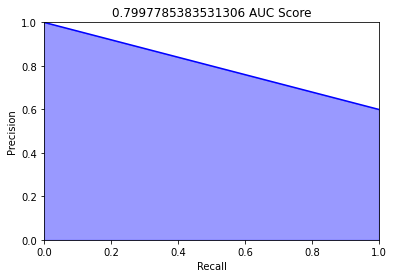

===================== LogisticRegressor =====================


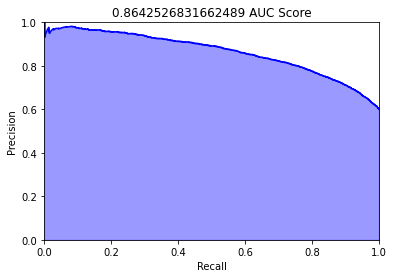

===================== MLPClassifier =====================


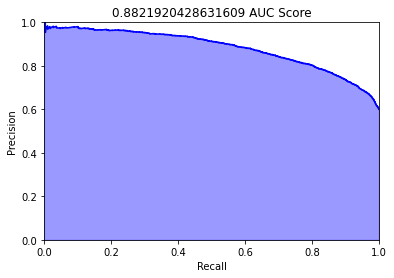

===================== RNNClassifier =====================


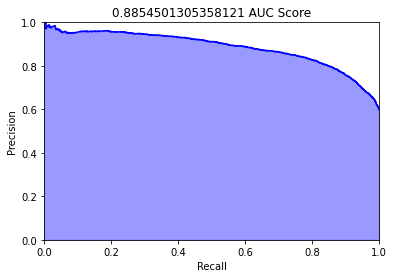

===================== CNNClassifier =====================


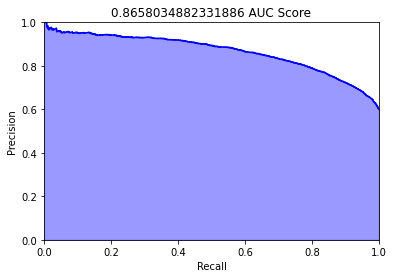

===================== CNNClassifier =====================


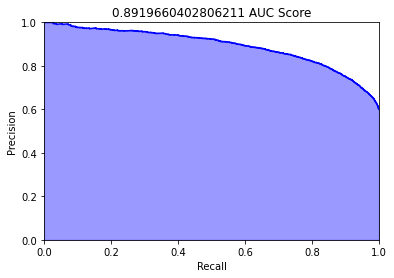

In [ ]:
# Plot the precision recall graphs with the auc scores for all the classifiers
pr_curve(classifiers,vocab,test_dataset,device=device)